In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import os.path
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

sns.set(style="white", palette="YlOrRd_r")

In [92]:
ROOT_DIR = os.path.abspath('.')
DATA_DIR = os.path.join(ROOT_DIR, 'data')
FILE = os.path.join(DATA_DIR, '{name_file}')

## Leitura dos dados e Qualidade dos dados

### Leitura PEDIDO

In [93]:
df_pedido = pd.read_excel(FILE.format(name_file='PEDIDO-_1_.xlsx'), names=['ID_PEDIDO', 'DATA', 'VALOR_TOTAL'])
df_pedido['ID_PEDIDO'] = df_pedido['ID_PEDIDO'].astype('object')
df_pedido

,ID_PEDIDO,DATA,VALOR_TOTAL
0,120210601,2021-06-01,NaN
1,220210601,2021-06-01,NaN
2,320210604,2021-06-04,NaN
3,420210604,2021-06-04,NaN
5,520210604,2021-06-04,NaN
...,...,...,...
287,14420210830,2021-08-30,NaN
288,14520210830,2021-08-30,NaN
289,14520210831,2021-08-31,NaN
292,14620210901,2021-09-01,NaN


### Verificar tipo dos dados e presença de valores nulos

In [94]:
df_pedido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 0 to 293
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_PEDIDO    181 non-null    object 
 1   DATA         181 non-null    object 
 2   VALOR_TOTAL  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 5.7+ KB


### Transformando coluna DATA para o formato datetime

In [95]:
df_pedido['DATA'] = pd.to_datetime(df_pedido['DATA'])
df_pedido

,ID_PEDIDO,DATA,VALOR_TOTAL
0,120210601,2021-06-01,NaN
1,220210601,2021-06-01,NaN
2,320210604,2021-06-04,NaN
3,420210604,2021-06-04,NaN
5,520210604,2021-06-04,NaN
...,...,...,...
287,14420210830,2021-08-30,NaN
288,14520210830,2021-08-30,NaN
289,14520210831,2021-08-31,NaN
292,14620210901,2021-09-01,NaN


### Verificando a presença de chave duplicada

In [96]:
df_contagem = df_pedido.groupby('ID_PEDIDO').size().reset_index(name='CTGM')
df_contagem = df_contagem.loc[(df_contagem['CTGM'] > 1), ['ID_PEDIDO']]
print(df_contagem)

del(df_contagem)

Empty DataFrame
Columns: [ID_PEDIDO]
Index: []


### Leitura ITEM_PEDIDO

In [97]:
df_item_pedido = pd.read_excel(FILE.format(name_file='ITEM_PEDIDO-_2_.xlsx'), names=['ID_PEDIDO', 'ID_ITEM', 'QUANTIDADE'])
df_item_pedido['ID_PEDIDO'] = df_item_pedido['ID_PEDIDO'].astype('object')
df_item_pedido

,ID_PEDIDO,ID_ITEM,QUANTIDADE
0,120210601,item C,4
1,220210601,item A,3
2,320210604,item C,1
3,420210604,item B,4
4,420210604,item C,2
...,...,...,...
290,14520210831,item C,5
291,14520210831,item A,3
292,14620210901,item D,2
293,14720210901,item A,1


### Verificar tipo dos dados e presença de valores nulos

In [98]:
df_item_pedido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 294
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_PEDIDO   295 non-null    object
 1   ID_ITEM     295 non-null    object
 2   QUANTIDADE  295 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 9.2+ KB


### Verificando a presença de dados duplicada

In [99]:
df_contagem = df_item_pedido.groupby(['ID_PEDIDO', 'ID_ITEM', 'QUANTIDADE']).size().reset_index(name='CTGM')
df_contagem = df_contagem.loc[(df_contagem['CTGM'] > 1), ['ID_PEDIDO']]
print(df_contagem)

       ID_PEDIDO
35    1820210615
50    3020210622
192  10120210731
226  11720210813


In [100]:
df_item_pedido.loc[df_item_pedido['ID_PEDIDO'].isin(df_contagem['ID_PEDIDO'])].sort_values(by=['ID_PEDIDO', 'ID_ITEM', 'QUANTIDADE'])

,ID_PEDIDO,ID_ITEM,QUANTIDADE
35,1820210615,item B,4
34,1820210615,item D,1
36,1820210615,item D,1
51,3020210622,item A,4
53,3020210622,item A,4
52,3020210622,item C,2
195,10120210731,item B,1
193,10120210731,item C,2
192,10120210731,item D,1
194,10120210731,item D,1


Observase a duplicadidade completa da linha, assim, optei por remover da tabela.

Ressalta-se que no cotidiano a informação precisa ser averiguada com a equipe de negócios.

In [101]:
df_item_pedido = df_item_pedido[['ID_PEDIDO', 'ID_ITEM', 'QUANTIDADE']].drop_duplicates()
df_item_pedido

,ID_PEDIDO,ID_ITEM,QUANTIDADE
0,120210601,item C,4
1,220210601,item A,3
2,320210604,item C,1
3,420210604,item B,4
4,420210604,item C,2
...,...,...,...
290,14520210831,item C,5
291,14520210831,item A,3
292,14620210901,item D,2
293,14720210901,item A,1


### Verificando itens

In [102]:
df_item_pedido['ID_ITEM'].unique()

array(['item C', 'item A', 'item B', 'item D'], dtype=object)

### Leitura ITENS

In [103]:
df_item = pd.read_excel(FILE.format(name_file='ITENS-_3_.xlsx'))
df_item = df_item.rename(columns={'Unnamed: 0': 'ID_ITEM', 0:'VALOR_ITEM'})
df_item

,ID_ITEM,VALOR_ITEM
0,item A,10
1,item B,15
2,item C,20
3,item D,25


### Verificar tipo dos dados e presença de valores nulos

In [104]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID_ITEM     4 non-null      object
 1   VALOR_ITEM  4 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes


### Consolidação do dataset

Adicionar preço dos itens

In [105]:
df = pd.merge(left=df_item_pedido, right=df_item, how='left', on='ID_ITEM')
df

,ID_PEDIDO,ID_ITEM,QUANTIDADE,VALOR_ITEM
0,120210601,item C,4,20
1,220210601,item A,3,10
2,320210604,item C,1,20
3,420210604,item B,4,15
4,420210604,item C,2,20
...,...,...,...,...
286,14520210831,item C,5,20
287,14520210831,item A,3,10
288,14620210901,item D,2,25
289,14720210901,item A,1,10


In [106]:
df = pd.merge(left=df, right=df_pedido[['ID_PEDIDO', 'DATA']], how='left', on='ID_PEDIDO')
df

,ID_PEDIDO,ID_ITEM,QUANTIDADE,VALOR_ITEM,DATA
0,120210601,item C,4,20,2021-06-01
1,220210601,item A,3,10,2021-06-01
2,320210604,item C,1,20,2021-06-04
3,420210604,item B,4,15,2021-06-04
4,420210604,item C,2,20,2021-06-04
...,...,...,...,...,...
286,14520210831,item C,5,20,2021-08-31
287,14520210831,item A,3,10,2021-08-31
288,14620210901,item D,2,25,2021-09-01
289,14720210901,item A,1,10,2021-09-01


Valor em reais das compras separadas por itens

In [107]:
df['VALOR'] = df['QUANTIDADE'] * df['VALOR_ITEM']
df

,ID_PEDIDO,ID_ITEM,QUANTIDADE,VALOR_ITEM,DATA,VALOR
0,120210601,item C,4,20,2021-06-01,80
1,220210601,item A,3,10,2021-06-01,30
2,320210604,item C,1,20,2021-06-04,20
3,420210604,item B,4,15,2021-06-04,60
4,420210604,item C,2,20,2021-06-04,40
...,...,...,...,...,...,...
286,14520210831,item C,5,20,2021-08-31,100
287,14520210831,item A,3,10,2021-08-31,30
288,14620210901,item D,2,25,2021-09-01,50
289,14720210901,item A,1,10,2021-09-01,10


In [108]:
df['ANO_MES'] = df['DATA'].dt.to_period('M')

In [109]:
df.groupby(['ANO_MES'], as_index=False).agg({'DATA':[min, max], 'ID_PEDIDO':'nunique'})

ANO_MES       DATA            ID_PEDIDO
                  min        max   nunique
0  2021-06 2021-06-01 2021-06-30        54
1  2021-07 2021-07-01 2021-07-31        71
2  2021-08 2021-08-01 2021-08-31        54
3  2021-09 2021-09-01 2021-09-01         2

In [110]:
df = df.loc[df['DATA'] != '2021-09']
df

,ID_PEDIDO,ID_ITEM,QUANTIDADE,VALOR_ITEM,DATA,VALOR,ANO_MES
0,120210601,item C,4,20,2021-06-01,80,2021-06
1,220210601,item A,3,10,2021-06-01,30,2021-06
2,320210604,item C,1,20,2021-06-04,20,2021-06
3,420210604,item B,4,15,2021-06-04,60,2021-06
4,420210604,item C,2,20,2021-06-04,40,2021-06
...,...,...,...,...,...,...,...
283,14420210830,item A,4,10,2021-08-30,40,2021-08
284,14520210830,item D,3,25,2021-08-30,75,2021-08
285,14520210831,item D,3,25,2021-08-31,75,2021-08
286,14520210831,item C,5,20,2021-08-31,100,2021-08


In [111]:
df.groupby(['ANO_MES'], as_index=False).agg({'DATA':[min, max], 'ID_PEDIDO':'nunique'})

ANO_MES       DATA            ID_PEDIDO
                  min        max   nunique
0  2021-06 2021-06-01 2021-06-30        54
1  2021-07 2021-07-01 2021-07-31        71
2  2021-08 2021-08-01 2021-08-31        54

Temos poucas amostras de vendas para o mês de Setembro, assim, irei ignorá-lo nas análises posteriores.

## Análise Descritiva

Intervalo de tempo das vendas

In [112]:
dt_min = df['DATA'].min().date()
dt_max = df['DATA'].max().date()
print(f'Intervalo de vendas de {dt_min.strftime("%d-%m-%y")} até {dt_max.strftime("%d-%m-%y")}')

Intervalo de vendas de 01-06-21 até 31-08-21


Informações gerais por Item

In [113]:
for item in sorted(df['ID_ITEM'].unique()):
    print(f'Informações descritivas do {item}')
    print(df[df['ID_ITEM'] == item].select_dtypes(exclude=['object', 'datetime64[ns]']).describe(), end='\n\n')

Informações descritivas do item A
       QUANTIDADE  VALOR_ITEM      VALOR
count   65.000000        65.0  65.000000
mean     3.169231        10.0  31.692308
std      1.442321         0.0  14.423205
min      1.000000        10.0  10.000000
25%      2.000000        10.0  20.000000
50%      3.000000        10.0  30.000000
75%      4.000000        10.0  40.000000
max      5.000000        10.0  50.000000

Informações descritivas do item B
       QUANTIDADE  VALOR_ITEM      VALOR
count   73.000000        73.0  73.000000
mean     2.972603        15.0  44.589041
std      1.394160         0.0  20.912407
min      1.000000        15.0  15.000000
25%      2.000000        15.0  30.000000
50%      3.000000        15.0  45.000000
75%      4.000000        15.0  60.000000
max      5.000000        15.0  75.000000

Informações descritivas do item C
       QUANTIDADE  VALOR_ITEM       VALOR
count   70.000000        70.0   70.000000
mean     3.014286        20.0   60.285714
std      1.527457         0.0   

Distribuição da quantidade de itens vendidos

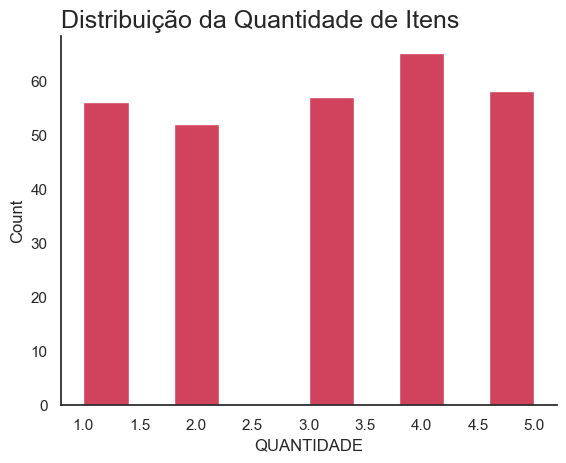

In [114]:
ax = sns.histplot(data=df, x="QUANTIDADE")
ax.set_title('Distribuição da Quantidade de Itens', loc='left', fontsize=18)
sns.despine(bottom = False, left = False)

Boxplot da quantidade de itens para observar o comportamento da distribuição e possível outliers 

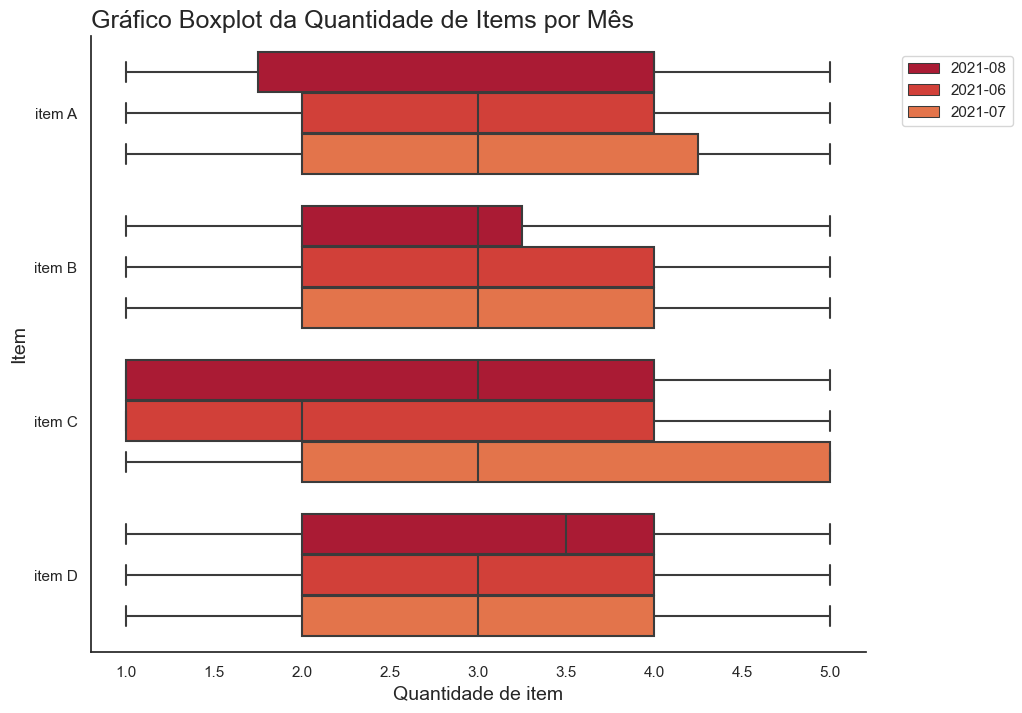

In [115]:
ax = sns.boxplot(data=df.sort_values(by=['ID_ITEM']), x="QUANTIDADE", y="ID_ITEM", hue='ANO_MES')
   
ax.figure.set_size_inches(10,8)
sns.despine(bottom = False, left = False)
ax.set_title('Gráfico Boxplot da Quantidade de Items por Mês', loc='left', fontsize=18)
sns.despine(bottom = False, left = False)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 0.98))
ax.set_xlabel('Quantidade de item', fontsize=14)
ax.set_ylabel('Item', fontsize=14);

Ticket médio das vendas por mês

In [116]:
df_vendas_mes =  df.groupby(['ANO_MES'], as_index=False).agg({'ID_PEDIDO':'nunique', 'VALOR':'sum'})
df_vendas_mes['TICKET_MEDIO'] = round(df_vendas_mes['VALOR'] / df_vendas_mes['ID_PEDIDO'], 2)
df_vendas_mes

,ANO_MES,ID_PEDIDO,VALOR,TICKET_MEDIO
0,2021-06,54,4100,75.93
1,2021-07,71,6500,91.55
2,2021-08,54,5110,94.63


Text(0, 0.5, 'Valor médio de venda (R$)')

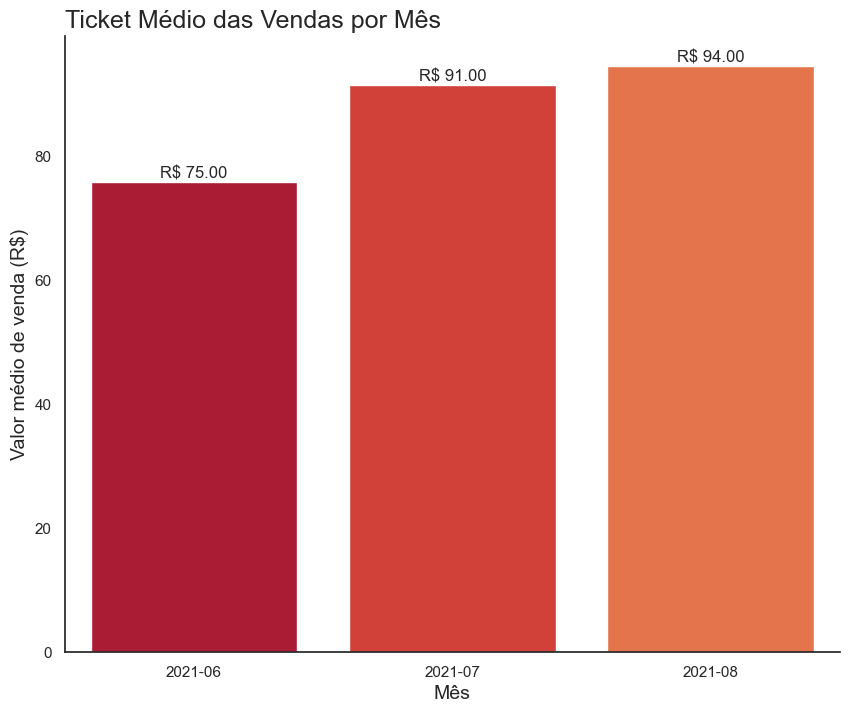

In [117]:
ax = sns.barplot(x='ANO_MES', y='TICKET_MEDIO', data=df_vendas_mes)

for p in ax.patches:
    ax.annotate(f'R$ {int(p.get_height()):.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
    
ax.figure.set_size_inches(10,8)
sns.despine(bottom = False, left = False)
ax.set_title('Ticket Médio das Vendas por Mês', loc='left', fontsize=18)
ax.set_xlabel('Mês', fontsize=14)
ax.set_ylabel('Valor médio de venda (R$)', fontsize=14)

Existem itens  que giram mais dinheiro que outros? Quais são?

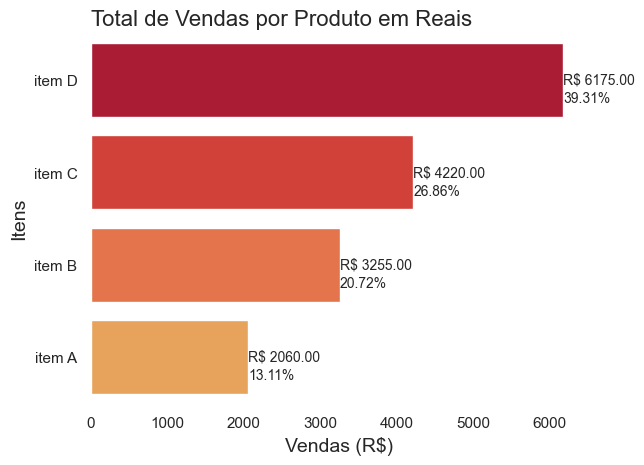

In [118]:
df_dinheiro = df.groupby(['ID_ITEM'], as_index=False).agg({'VALOR':'sum'}).sort_values(by=['VALOR'], ascending=False)
df_dinheiro['PERC'] = round((df_dinheiro['VALOR'] / df_dinheiro['VALOR'].sum()) * 100, 2)

ax = sns.barplot(x='VALOR', y='ID_ITEM', data=df_dinheiro)
for i, p in enumerate(ax.patches):
    ax.annotate(f'R$ {int(p.get_width()):.2f}', (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', fontsize=10)
    ax.annotate(f'{df_dinheiro["PERC"].iloc[i]}%', (p.get_x() + p.get_width(), p.get_y() + 0.6), va='center', fontsize=10)


sns.despine(bottom = True, left = True)
ax.set_title('Total de Vendas por Produto em Reais', loc='left', fontsize=16)
ax.set_xlabel('Vendas (R$)', fontsize=14)
ax.set_ylabel('Itens', fontsize=14);

Quais são os itens mais vendidos por quantidade

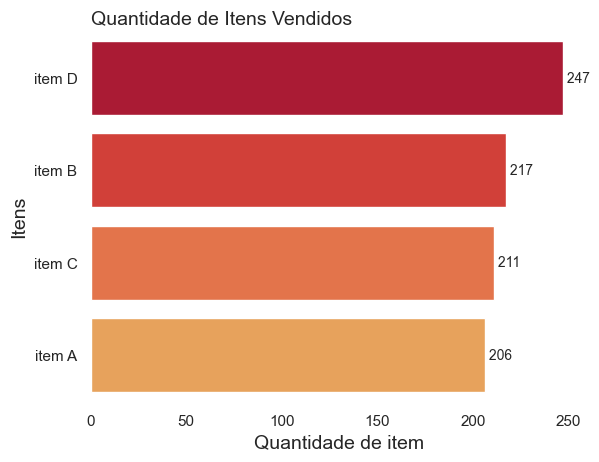

In [119]:
df_qtd = df.groupby(['ID_ITEM'], as_index=False).agg({'QUANTIDADE':'sum'}).sort_values(by=['QUANTIDADE'], ascending=False)

ax = sns.barplot(x='QUANTIDADE', y='ID_ITEM', data=df_qtd)

for i, p in enumerate(ax.patches):
    ax.annotate(f' {int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', fontsize=10)
sns.despine(bottom = True, left = True)    

ax.set_title(f'Quantidade de Itens Vendidos', loc='left', fontsize=14)
ax.set_xlabel('Quantidade de item', fontsize=14)
ax.set_ylabel('Itens', fontsize=14);

Quantidade de itens vendido em média

In [147]:
df_qtd['QUANTIDADE'].mean()

220.25

Qual foi a mês que mais vendemos em termos de quantidade de item

In [120]:
df_qtd_venda = df.groupby(['ANO_MES', 'ID_ITEM'], as_index=False).agg({'QUANTIDADE':'sum', 'VALOR':'sum'}).sort_values(by=['ANO_MES'], ascending=True)
df_qtd_venda

,ANO_MES,ID_ITEM,QUANTIDADE,VALOR
0,2021-06,item A,50,500
1,2021-06,item B,75,1125
2,2021-06,item C,45,900
3,2021-06,item D,63,1575
4,2021-07,item A,80,800
5,2021-07,item B,87,1305
6,2021-07,item C,96,1920
7,2021-07,item D,99,2475
8,2021-08,item A,76,760
9,2021-08,item B,55,825


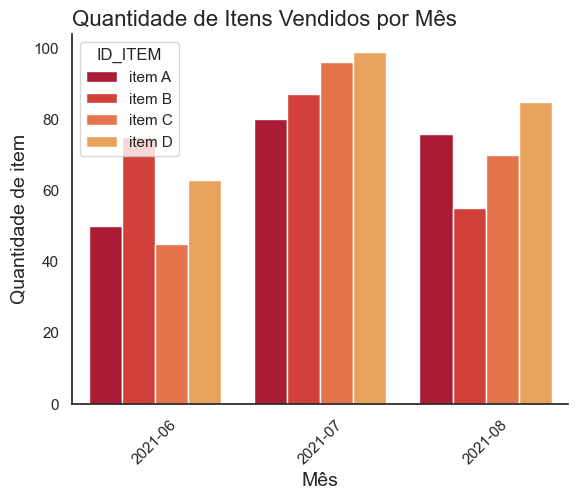

In [121]:
ax = sns.barplot(x='ANO_MES', y='QUANTIDADE', hue='ID_ITEM', data=df_qtd_venda)
ax.set_title('Quantidade de Itens Vendidos por Mês', loc='left', fontsize=16)
ax.set_xlabel('Mês', fontsize=14)
ax.set_ylabel('Quantidade de item', fontsize=14)
sns.despine(bottom = False, left = False)
ax.tick_params(axis='x', rotation=45);

Qual foi a mês que mais vendemos em termos de valor

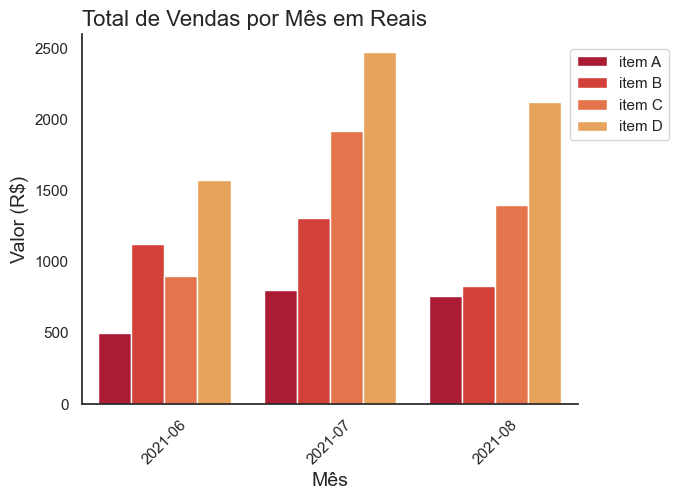

In [142]:
ax = sns.barplot(x='ANO_MES', y='VALOR', hue='ID_ITEM', data=df_qtd_venda)
ax.set_title('Total de Vendas por Mês em Reais', loc='left', fontsize=16)
ax.set_xlabel('Mês', fontsize=14)
ax.set_ylabel('Valor (R$)', fontsize=14)
ax.legend(loc='upper right')
sns.despine(bottom = False, left = False)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 0.98))
ax.tick_params(axis='x', rotation=45);

Total de Vendas por Mês em Reais

5236.666666666667

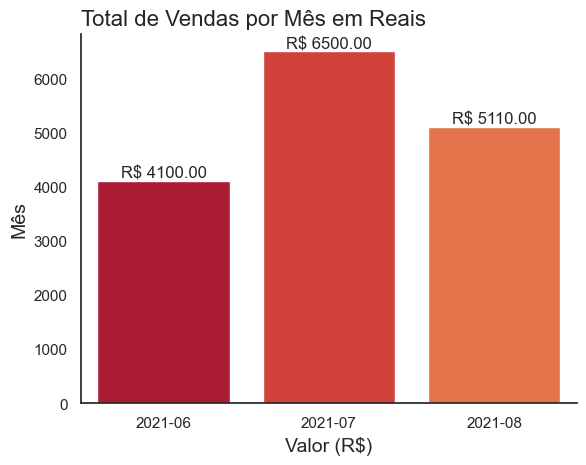

In [123]:
df_qtd_venda_mes = df.groupby(['ANO_MES'], as_index=False).agg({'VALOR':'sum'}).sort_values(by=['ANO_MES'], ascending=True)


ax = sns.barplot(x='ANO_MES', y='VALOR', data=df_qtd_venda_mes)
for i, p in enumerate(ax.patches):
    ax.annotate(f'R$ {p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

sns.despine(bottom = False, left = False)

ax.set_title('Total de Vendas por Mês em Reais', loc='left', fontsize=16)
ax.set_xlabel('Valor (R$)', fontsize=14)
ax.set_ylabel('Mês', fontsize=14);

Venda em média

In [145]:
df_qtd_venda_mes['VALOR'].mean()

5236.666666666667

Qual o ciclo médio de compras em dia?

In [124]:
df_ciclo_compra = df.sort_values(by=['ID_ITEM', 'DATA'])

# Calcular a diferença de dias entre compras consecutivas para cada item
df_ciclo_compra['DIAS_ENTRE_COMPRAS'] = df_ciclo_compra.groupby('ID_ITEM')['DATA'].diff().dt.days

# Calcular o ciclo médio de compra para cada item
ciclo_medio_compra = df_ciclo_compra.groupby('ID_ITEM', as_index=False).agg({'DIAS_ENTRE_COMPRAS':'mean'})

ciclo_medio_compra

,ID_ITEM,DIAS_ENTRE_COMPRAS
0,item A,1.421875
1,item B,1.194444
2,item C,1.318841
3,item D,1.113924


In [148]:
ciclo_medio_compra['DIAS_ENTRE_COMPRAS'].mean()

1.2622710186968753

### Como está a tendência das vendas, de crescimento ou queda?

quantidade de itens vendidos por dia

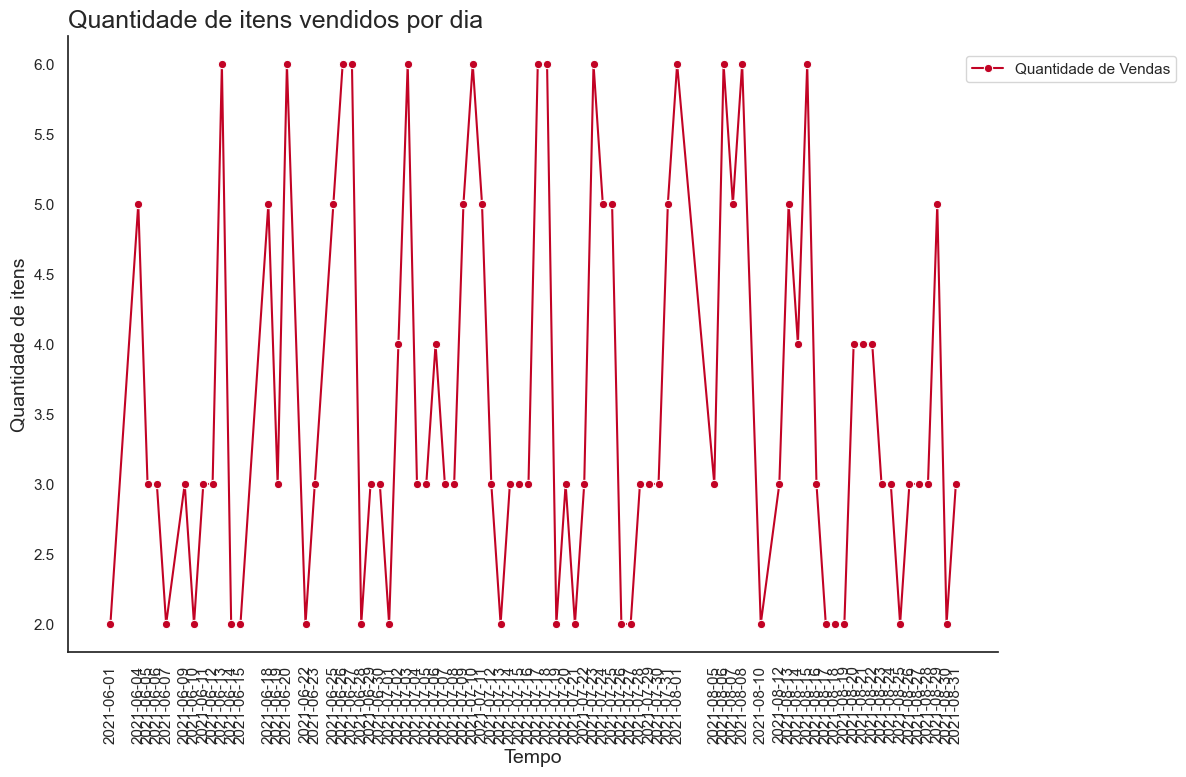

In [125]:
df_vendas = df.groupby('DATA', as_index=False).agg({'QUANTIDADE':'count'})

ax = sns.lineplot(x='DATA', y='QUANTIDADE', data=df_vendas, label='Quantidade de Vendas', marker="o")

ax.figure.set_size_inches(12,8)
ax.set_title('Quantidade de itens vendidos por dia', loc='left', fontsize=18)
ax.set_xlabel('Tempo', fontsize=14)
ax.set(xticks=df_vendas['DATA'])

ax.set_ylabel('Quantidade de itens', fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 0.98))
sns.despine(bottom = False, left = False)


ax.tick_params(axis='x', rotation=90);

Histórico de vendas semanais

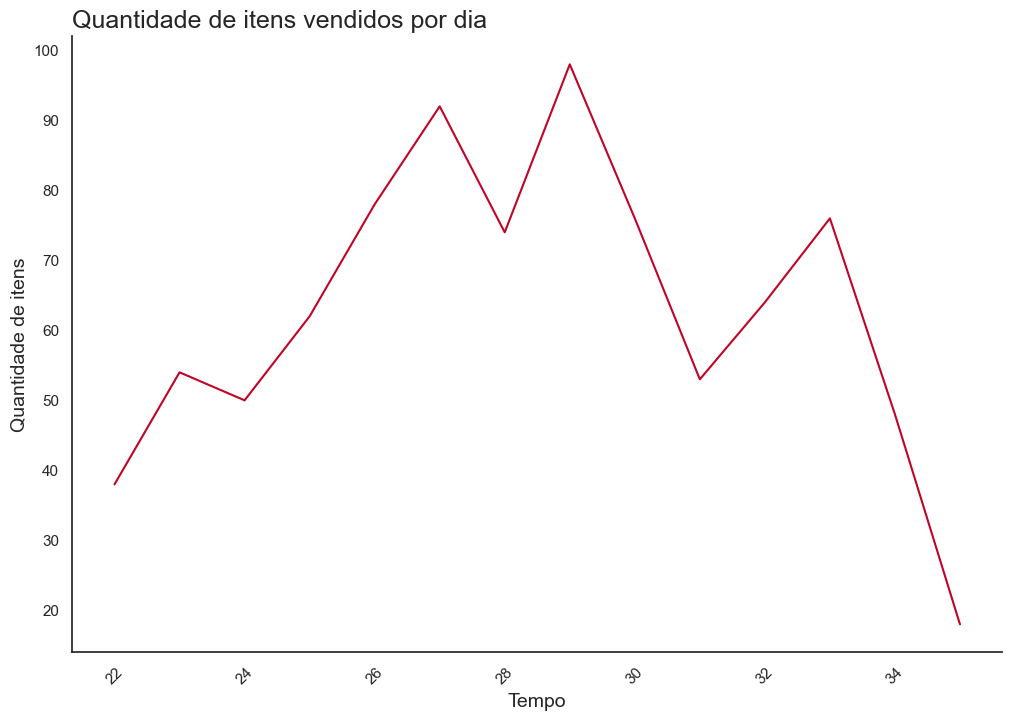

In [126]:
df_vendas_por_semana = df.groupby([df['DATA'].dt.isocalendar().week])['QUANTIDADE'].sum().reset_index()
df_vendas_por_semana['week'] = df_vendas_por_semana['week'].astype('int64')

ax = sns.lineplot(x='week', y='QUANTIDADE', data=df_vendas_por_semana)
ax.figure.set_size_inches(12,8)
ax.set_title('Quantidade de itens vendidos por dia', loc='left', fontsize=18)
ax.set_xlabel('Tempo', fontsize=14)
ax.set_ylabel('Quantidade de itens', fontsize=14)
sns.despine(bottom = False, left = False)


ax.tick_params(axis='x', rotation=45);

Histórico de vendas diárias separados por item

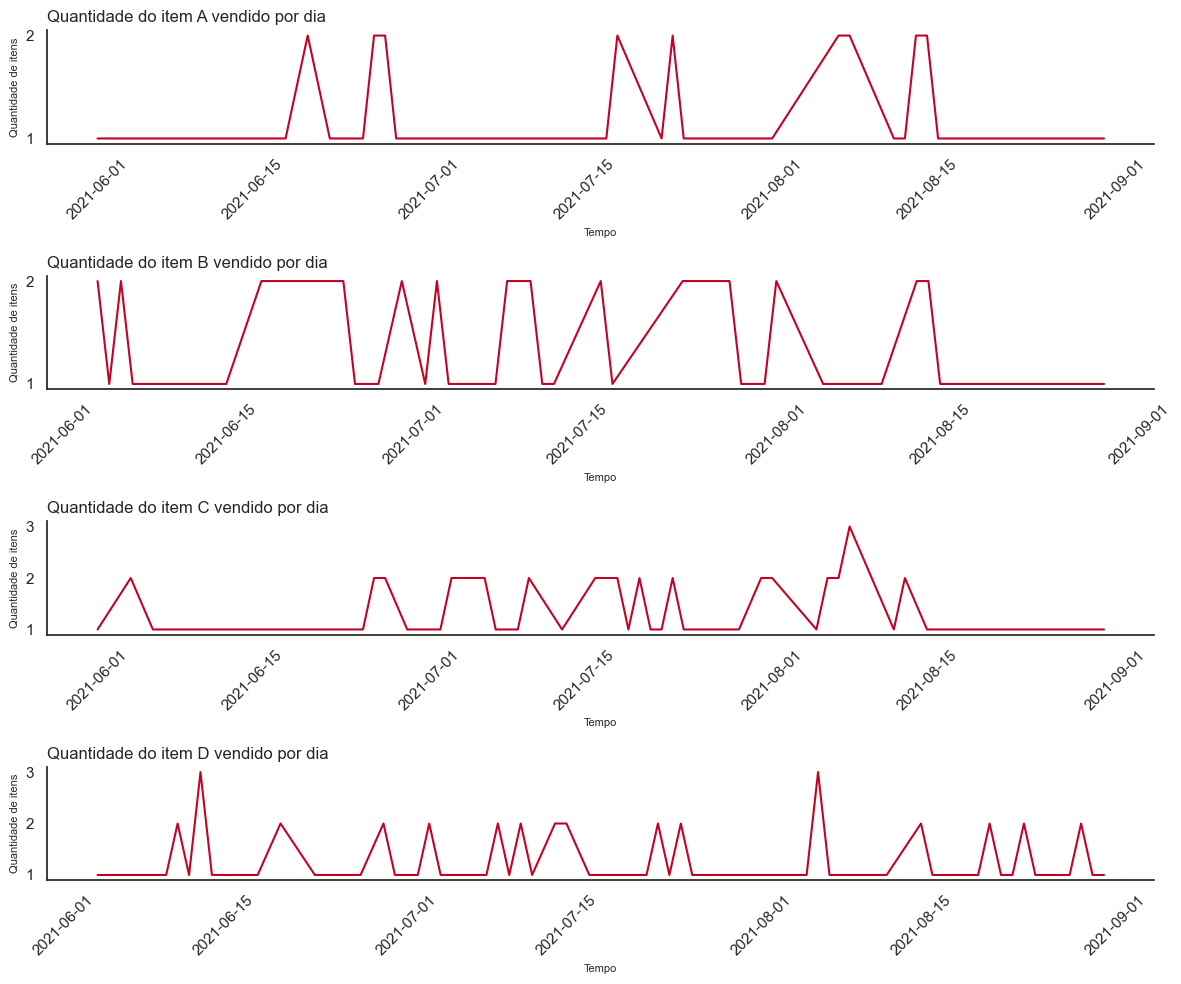

In [127]:
df_vendas = df.groupby(['DATA', 'ID_ITEM'], as_index=False).agg({'QUANTIDADE':'count'})
df_vendas['QUANTIDADE'] = df_vendas['QUANTIDADE'].astype('int64')

fig, ax = plt.subplots(4, figsize=(12, 10))
ax = ax.ravel()

for i, item in enumerate(sorted(df['ID_ITEM'].unique())):
    sns.lineplot(x='DATA', y='QUANTIDADE', data=df_vendas[df_vendas['ID_ITEM'] == item], ax=ax[i])
    ax[i].figure.set_size_inches(12,10)
    ax[i].set_title(f'Quantidade do {item} vendido por dia', loc='left', fontsize=12)
    ax[i].set_xlabel('Tempo', fontsize=8)
    ax[i].set_ylabel('Quantidade de itens', fontsize=8)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax[i].tick_params(axis='x', rotation=45);

sns.despine(bottom = False, left = False)


plt.subplots_adjust(wspace=0.7, hspace=0.4)
plt.tight_layout()


Histórico de vendas semanais separados por item

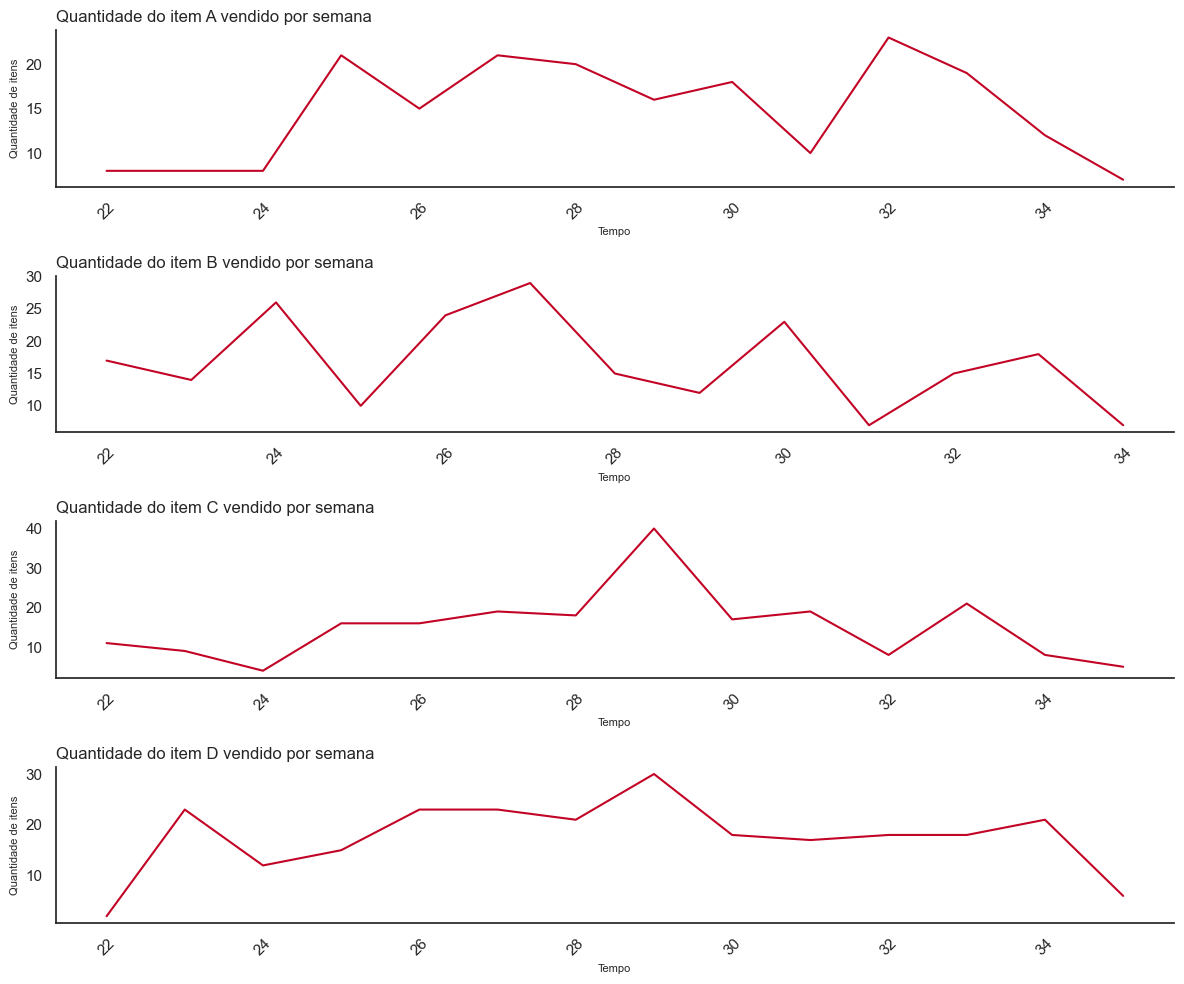

In [128]:
df_vendas_por_semana = df.groupby([df['DATA'].dt.isocalendar().week, 'ID_ITEM'])['QUANTIDADE'].sum().reset_index()
df_vendas_por_semana['week'] = df_vendas_por_semana['week'].astype('int64')

fig, ax = plt.subplots(4, figsize=(12, 10))
ax = ax.ravel()

for i, item in enumerate(sorted(df['ID_ITEM'].unique())):
    sns.lineplot(x='week', y='QUANTIDADE', data=df_vendas_por_semana[df_vendas_por_semana['ID_ITEM'] == item], ax=ax[i])
    ax[i].set_title(f'Quantidade do {item} vendido por semana', loc='left', fontsize=12)
    ax[i].set_xlabel('Tempo', fontsize=8)
    ax[i].set_ylabel('Quantidade de itens', fontsize=8)
    ax[i].tick_params(axis='x', rotation=45)

sns.despine(bottom = False, left = False)
plt.subplots_adjust(wspace=0.7, hspace=0.4)
plt.tight_layout()

## Decomposição das séries

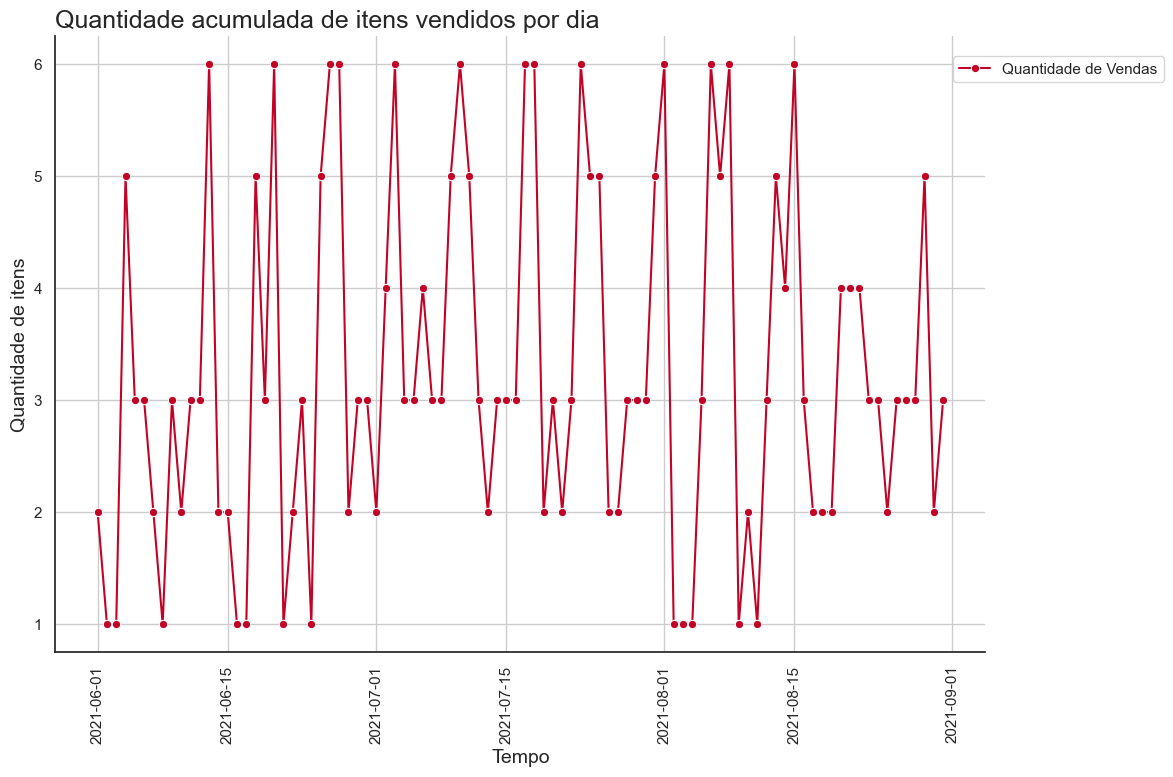

In [129]:
df_ts = df[['DATA', 'ID_ITEM', 'QUANTIDADE']]

start_date = str(df_ts['DATA'].min().date())
end_date = str(df_ts['DATA'].max().date())

df_ts = df_ts.set_index('DATA')

date_range = pd.date_range(start=start_date, end=end_date)
df_dt = pd.DataFrame(index=date_range)

# df_ts = df_ts.set_index('DATA')
df_full = df_dt.merge(df_ts, left_index=True, right_index=True, how='left')

# Preencha os valores ausentes com zero
df_full['QUANTIDADE'].fillna(0, inplace=True)
df_full['QUANTIDADE'] = df_full['QUANTIDADE'].astype('int64')


df_vendas = df_full.groupby(df_full.index).agg({'QUANTIDADE':'count'})

ax = sns.lineplot(x=df_vendas.index, y='QUANTIDADE', data=df_vendas, label='Quantidade de Vendas', marker="o")

ax.figure.set_size_inches(12,8)
ax.set_title('Quantidade acumulada de itens vendidos por dia', loc='left', fontsize=18)
ax.set_xlabel('Tempo', fontsize=14)
ax.grid(True)
ax.set_ylabel('Quantidade de itens', fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 0.98))
sns.despine(bottom = False, left = False)


ax.tick_params(axis='x', rotation=90);

<Figure size 1200x1000 with 0 Axes>

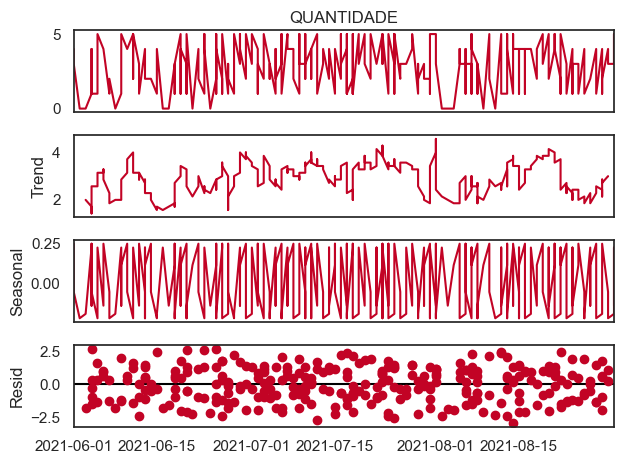

In [130]:
plt.figure(figsize=(12,10))
resultado = seasonal_decompose(df_full['QUANTIDADE'], period=7)
ax = resultado.plot()

<Figure size 1200x1000 with 0 Axes>

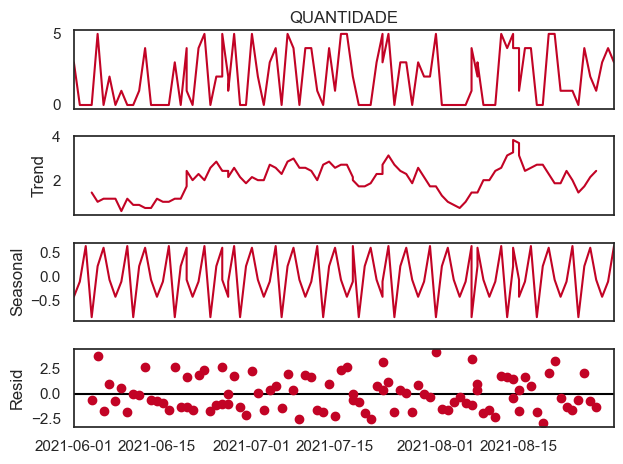

In [131]:
df_full_a = df_dt.merge(df_ts.loc[df_ts['ID_ITEM'] == 'item A'], left_index=True, right_index=True, how='left')

# Preencha os valores ausentes com zero
df_full_a['QUANTIDADE'].fillna(0, inplace=True)
df_full_a['QUANTIDADE'] = df_full_a['QUANTIDADE'].astype('int64')

plt.figure(figsize=(12,10))
resultado = seasonal_decompose(df_full_a['QUANTIDADE'], period=7)
ax = resultado.plot()

<Figure size 1200x1000 with 0 Axes>

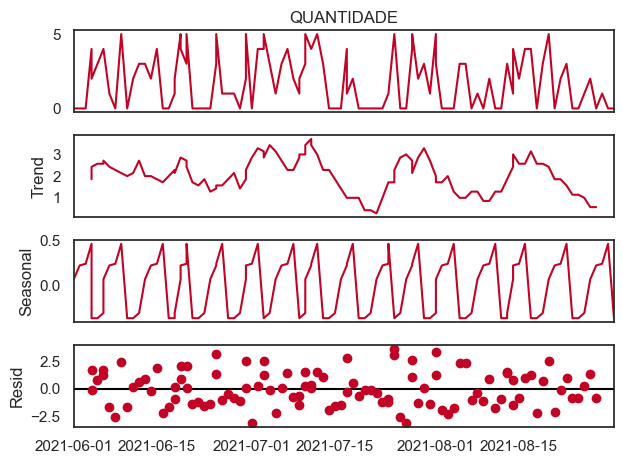

In [132]:
df_full_b = df_dt.merge(df_ts.loc[df_ts['ID_ITEM'] == 'item B'], left_index=True, right_index=True, how='left')

# Preencha os valores ausentes com zero
df_full_b['QUANTIDADE'].fillna(0, inplace=True)
df_full_b['QUANTIDADE'] = df_full_b['QUANTIDADE'].astype('int64')

plt.figure(figsize=(12,10))
resultado = seasonal_decompose(df_full_b['QUANTIDADE'], period=7)
ax = resultado.plot()

<Figure size 1200x1000 with 0 Axes>

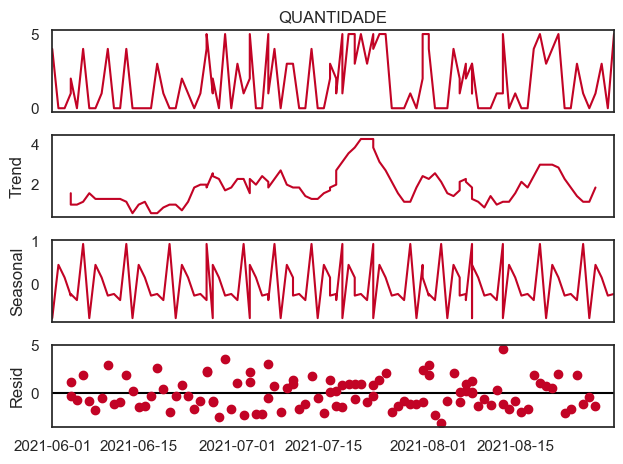

In [133]:
df_full_c = df_dt.merge(df_ts.loc[df_ts['ID_ITEM'] == 'item C'], left_index=True, right_index=True, how='left')

# Preencha os valores ausentes com zero
df_full_c['QUANTIDADE'].fillna(0, inplace=True)
df_full_c['QUANTIDADE'] = df_full_c['QUANTIDADE'].astype('int64')

plt.figure(figsize=(12,10))
resultado = seasonal_decompose(df_full_c['QUANTIDADE'], period=7)
ax = resultado.plot()

<Figure size 1200x1000 with 0 Axes>

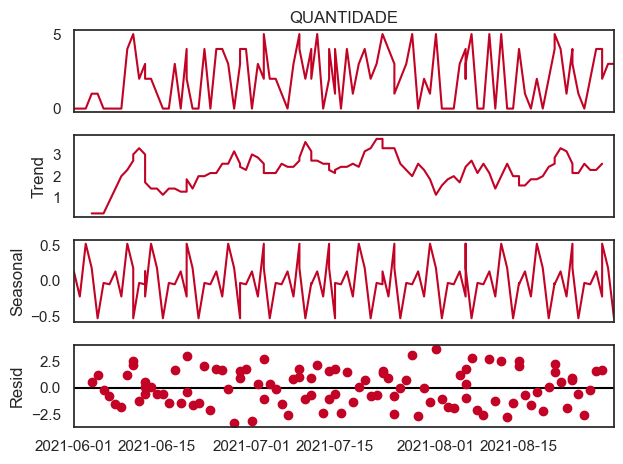

In [134]:
df_full_d = df_dt.merge(df_ts.loc[df_ts['ID_ITEM'] == 'item D'], left_index=True, right_index=True, how='left')

# Preencha os valores ausentes com zero
df_full_d['QUANTIDADE'].fillna(0, inplace=True)
df_full_d['QUANTIDADE'] = df_full_d['QUANTIDADE'].astype('int64')

plt.figure(figsize=(12,10))
resultado = seasonal_decompose(df_full_d['QUANTIDADE'], period=7)
ax = resultado.plot()

Todas as séries apresentam sazonalidade, ou seja, o histórico de demanda apresenta padrões que ocorrem em intervalos fixos, porém não é possível observar tendências e ciclos.

## Teste de estacionariedade

In [135]:
def test_dickey_fuller(valores):
    # Realizando o teste Dickey-Fuller
    resultado_teste = adfuller(valores)

    adf_statistic = resultado_teste[0]
    p_valor = resultado_teste[1]
    valores_criticos = resultado_teste[4]

    print("Estatística ADF:", adf_statistic)
    print("P-valor:", p_valor)
    print("Valores críticos:", valores_criticos)


    if p_valor < 0.05:
        print("O p-valor é menor que 0.05, rejeitamos a hipótese nula. A série é estacionária.", end='\n\n')
    else:
        print("O p-valor é maior ou igual a 0.05, não podemos rejeitar a hipótese nula. A série não é estacionária.", end='\n\n')

In [136]:
test_dickey_fuller(df_full['QUANTIDADE'])
test_dickey_fuller(df_full_a['QUANTIDADE'])
test_dickey_fuller(df_full_b['QUANTIDADE'])
test_dickey_fuller(df_full_c['QUANTIDADE'])
test_dickey_fuller(df_full_d['QUANTIDADE'])

Estatística ADF: -8.623715091865403
P-valor: 6.008642597860979e-14
Valores críticos: {'1%': -3.452636878592149, '5%': -2.8713543954331433, '10%': -2.5719993576515705}
O p-valor é menor que 0.05, rejeitamos a hipótese nula. A série é estacionária.

Estatística ADF: -5.089644680536338
P-valor: 1.47069457851954e-05
Valores críticos: {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}
O p-valor é menor que 0.05, rejeitamos a hipótese nula. A série é estacionária.

Estatística ADF: -3.983382227499448
P-valor: 0.0015000705754639175
Valores críticos: {'1%': -3.4989097606014496, '5%': -2.891516256916761, '10%': -2.5827604414827157}
O p-valor é menor que 0.05, rejeitamos a hipótese nula. A série é estacionária.

Estatística ADF: -9.329261802305686
P-valor: 9.425093106649517e-16
Valores críticos: {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}
O p-valor é menor que 0.05, rejeitamos a hipótese nula. A série é estacionária.

Estatísti

## Auto-correlação

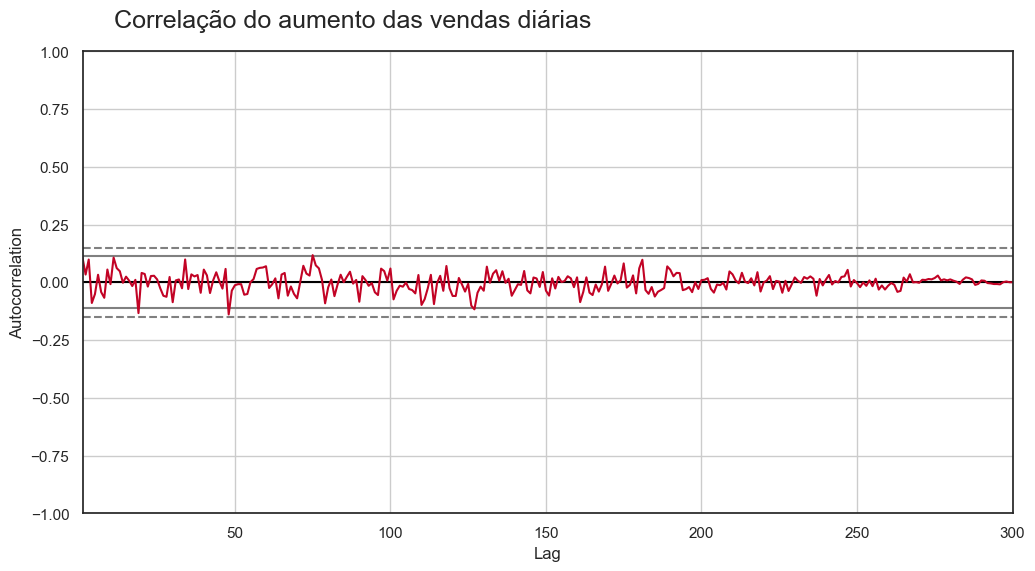

In [137]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlação do aumento das vendas diárias', fontsize=18, x=0.35, y=0.95)
autocorrelation_plot(df_full['QUANTIDADE']);

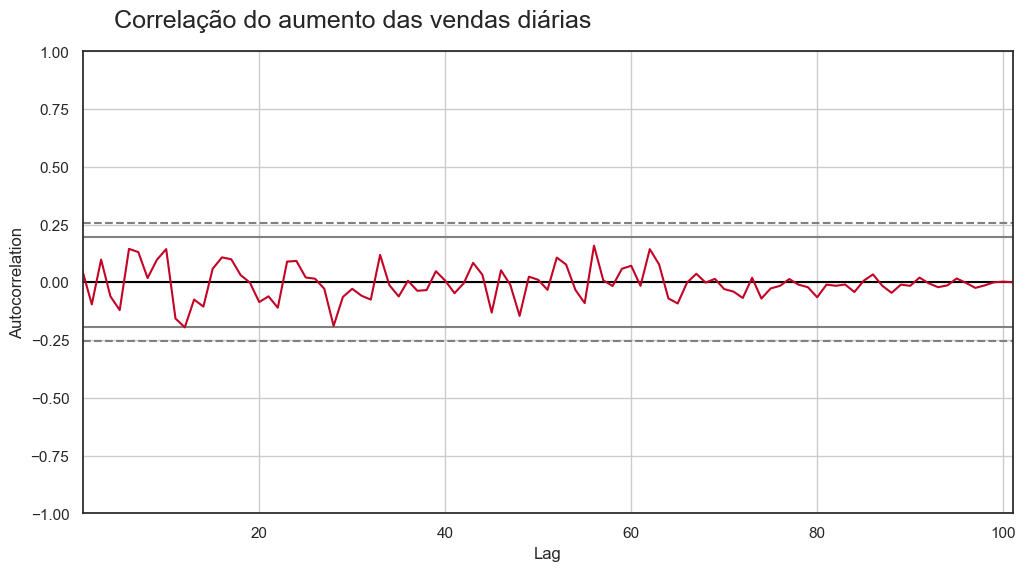

In [138]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlação do aumento das vendas diárias', fontsize=18, x=0.35, y=0.95)
autocorrelation_plot(df_full_a['QUANTIDADE']);

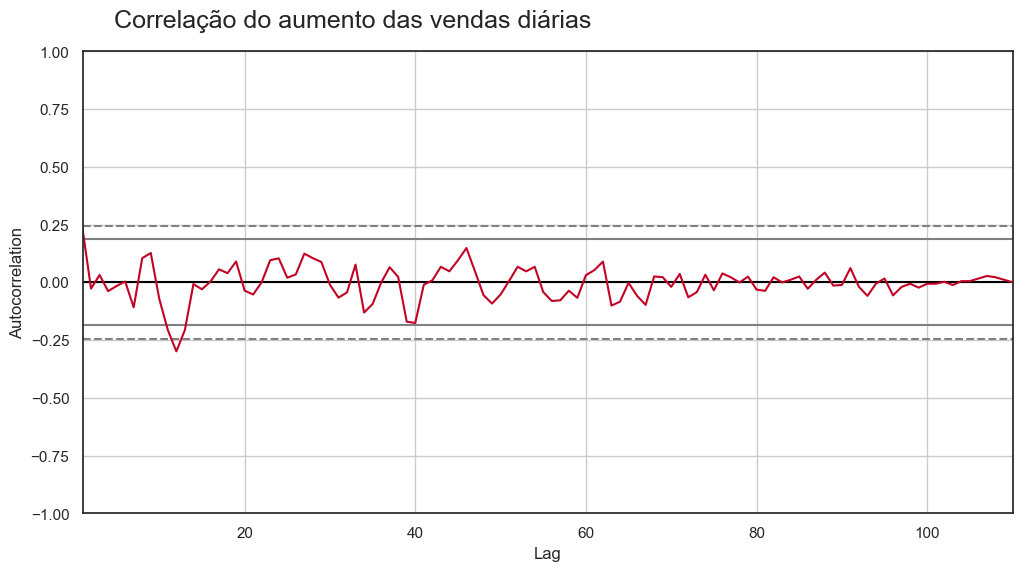

In [139]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlação do aumento das vendas diárias', fontsize=18, x=0.35, y=0.95)
autocorrelation_plot(df_full_b['QUANTIDADE']);

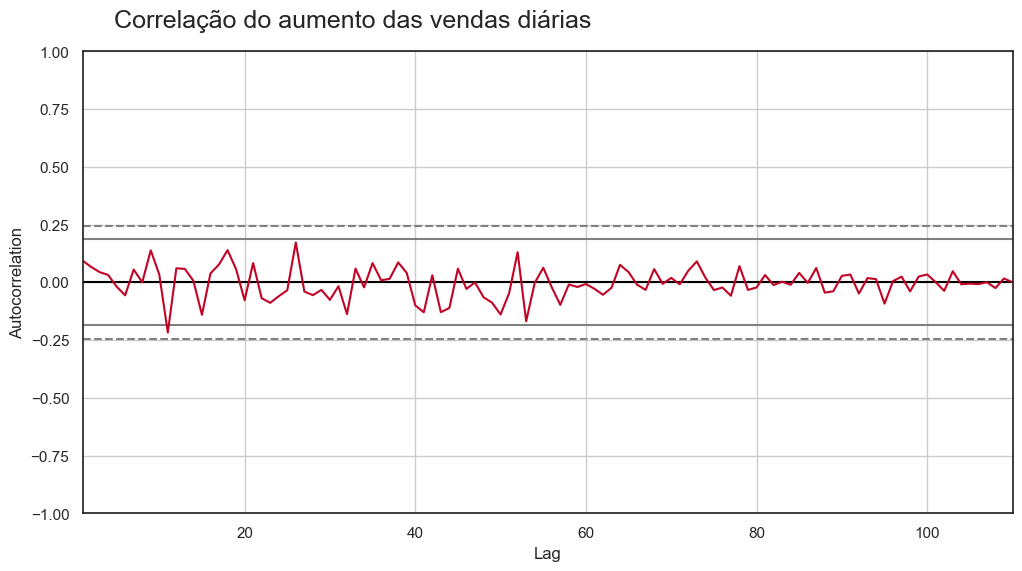

In [140]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlação do aumento das vendas diárias', fontsize=18, x=0.35, y=0.95)
autocorrelation_plot(df_full_c['QUANTIDADE']);

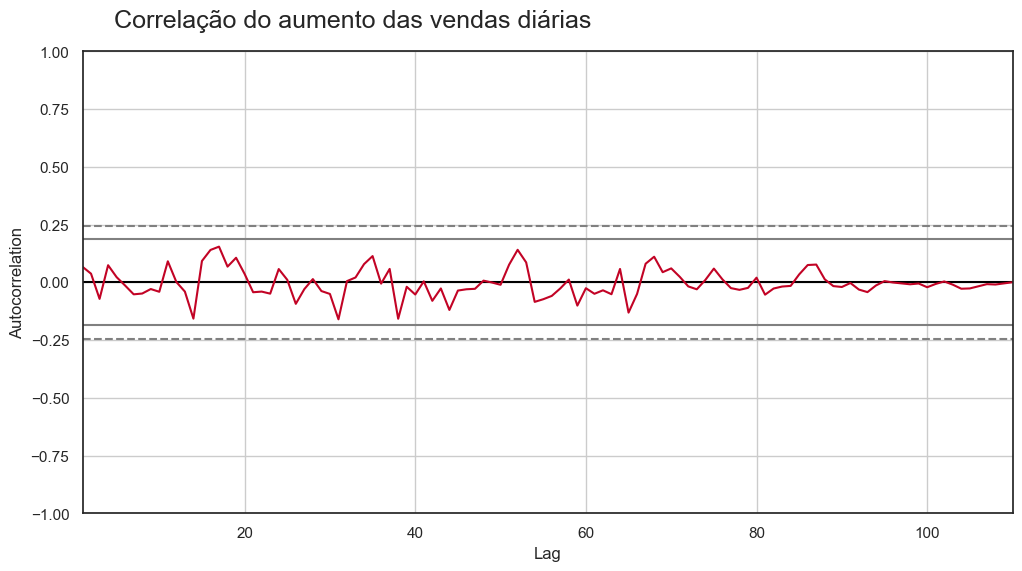

In [141]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlação do aumento das vendas diárias', fontsize=18, x=0.35, y=0.95)
autocorrelation_plot(df_full_d['QUANTIDADE']);

Não é detectado autocorrelação em nenhuma das séries, podendo assim, efetuar a tomada de decisão sem que os vieses do histórico posso afetar a predição.